In [24]:
from matplotlib import pyplot as plt
import csv
import os
import numpy as np
import pandas as pd
import pickle
import math
from tqdm import tqdm 
import collections
import statsmodels

from PIL import Image

import seaborn as sns
import torch.nn as nn
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torchvision.io import read_image
from torch.optim import SGD, Adam
from torch.autograd import Variable

from torchvision.models import resnet18, ResNet18_Weights

from crp.image import imgify, vis_opaque_img, plot_grid
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.causal_effects import CausalEffects
from tigramite.lpcmci import LPCMCI
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.regressionCI import RegressionCI


%matplotlib inline

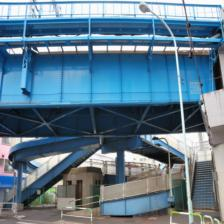

In [28]:
image_path = "NetDissect/dataset/broden1_224/images/"
image = Image.open(f'{image_path}{minidataset[0]["image"]}')
image

In [26]:
net_path = "NetDissect/dataset/broden1_224/index.csv"

def get_minidataset():
    with open(net_path, newline='') as csvfile:
        datainfo = csv.DictReader(csvfile, delimiter=',')
        i = 0
        minidataset = []
        for r in datainfo:
            if i < 100:
                i+=1
                minidataset += [r]
            else:
                break
        return minidataset
minidataset = get_minidataset()

In [61]:
#from NetDissect import settings
class Settings():
    MODEL="resnet18"
    MODEL_FILE="NetDissect/zoo/resnet18_places365.pth.tar"
    NUM_CLASSES=365
    MODEL_PARALLEL=True
    FEATURE_NAMES=['layer4']
    GPU=False  
    WORKERS = 12
    BATCH_SIZE = 128
    TALLY_BATCH_SIZE = 16
    TALLY_AHEAD = 4
    INDEX_FILE = 'NetDissect/index.csv'
    DATA_DIRECTORY = 'NetDissect/dataset/broden1_224'
    IMG_SIZE = 224
    CATAGORIES = ["object", "part","scene","texture","color"] # concept categories that are chosen to detect: "object", "part", "scene", "material", "texture", "color"
    
settings = Settings()
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

def loadmodel(hook_fn):
    if settings.MODEL_FILE is None:
        model = torchvision.models.__dict__[settings.MODEL](pretrained=True)
    else:
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
        checkpoint = torch.load(settings.MODEL_FILE, map_location=torch.device('cpu'))
        if type(checkpoint).__name__ == 'OrderedDict' or type(checkpoint).__name__ == 'dict':
            model = torchvision.models.__dict__[settings.MODEL](num_classes=settings.NUM_CLASSES)
            if settings.MODEL_PARALLEL:
                state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint[
                    'state_dict'].items()}  # the data parallel layer will add 'module' before each layer name
            else:
                state_dict = checkpoint
            model.load_state_dict(state_dict)
        else:
            model = checkpoint
    for name in settings.FEATURE_NAMES:
        model._modules.get(name).register_forward_hook(hook_fn)
    if settings.GPU:
        model.cuda()
    model.eval()
    return model



In [ ]:
class NetDissectDataset(Dataset):
    def __init__(self, train=True, transform=None):
        self.train = train
        self.dataset = SegmentationData(settings.DATA_DIRECTORY, categories=settings.CATAGORIES)
        self.transform = transforms.Compose([
            transforms.PILToTensor()
        ])

    def __len__(self):
        return self.dataset.size()

    def __getitem__(self, index):
        img_path = self.dataset.filename(index)
        image = Image.open(img_path)
        img_tensor = transform(image)
        target = self.labels[index][1]
        if not self.train:
            return (img_tensor, target, index)
        return (img_tensor, target)

In [62]:
model = loadmodel(hook_feature)

In [63]:
from NetDissect.loader.data_loader import SegmentationData, SegmentationPrefetcher

mean = [109.5388,118.6897,124.6901]

dissect_dataset = SegmentationData(settings.DATA_DIRECTORY, categories=settings.CATAGORIES)
training_loader = SegmentationPrefetcher(dissect_dataset,categories=['image'],once=True,batch_size=settings.BATCH_SIZE)

In [91]:
# test run
from torch.autograd import Variable as V
batch = training_loader.fetch_tensor_batch()
input = batch[0]
input = torch.from_numpy(input[:, ::-1, :, :].copy())
input.div_(255.0 * 0.224)

with torch.no_grad():
    input_var = V(input)
    logit = model(input_var)
print(logit.shape)

torch.Size([128, 365])


In [90]:
dissect_dataset.metadata(500)

('NetDissect/dataset/broden1_224',
 {'image': 'ade20k/ADE_train_00016984.jpg',
  'split': 'train',
  'ih': 224,
  'iw': 224,
  'sh': 112,
  'sw': 112,
  'color': ['ade20k/ADE_train_00016984_color.png'],
  'object': ['ade20k/ADE_train_00016984_object.png'],
  'part': ['ade20k/ADE_train_00016984_part_1.png'],
  'material': [],
  'scene': [59],
  'texture': []})

In [66]:
# Feature Visualization:
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
#canonizers = [SequentialMergeBatchNorm()]

composite = EpsilonPlusFlat()

cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names }

attribution = CondAttribution(model)

fv_path = "crp-stuff/dissect"
fv = FeatureVisualization(attribution, dissect_dataset, layer_map, path=fv_path)
layer_names

['conv1',
 'layer1.0.conv1',
 'layer1.0.conv2',
 'layer1.1.conv1',
 'layer1.1.conv2',
 'layer2.0.conv1',
 'layer2.0.conv2',
 'layer2.0.downsample.0',
 'layer2.1.conv1',
 'layer2.1.conv2',
 'layer3.0.conv1',
 'layer3.0.conv2',
 'layer3.0.downsample.0',
 'layer3.1.conv1',
 'layer3.1.conv2',
 'layer4.0.conv1',
 'layer4.0.conv2',
 'layer4.0.downsample.0',
 'layer4.1.conv1',
 'layer4.1.conv2',
 'fc']

In [21]:
# it will take approximately 20 min on a Titan RTX
saved_files = fv.run(composite, 0, len(dissect_dataset.image), 20, 100)

Running Analysis...


100%|█████████████████████████████████████| 25805/25805 [14:51<00:00, 28.94it/s]


100%|█████████████████████████████████████| 3108/3108 [00:01<00:00, 1611.04it/s]


tensor([7, 1, 4, 5, 0, 6]) tensor([50.7228, 17.4041,  2.2624,  0.0000,  0.0000, -3.7359])
tensor(1) 10


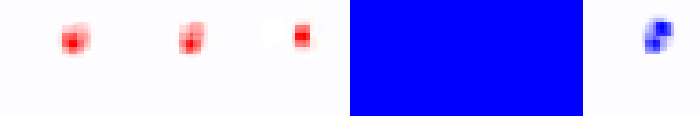

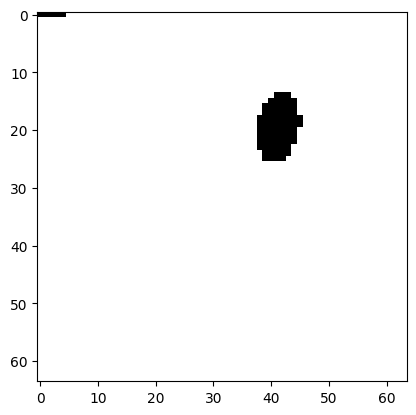

In [32]:
dataiter = iter(ci_loader)
images, labels = next(dataiter)
images = images.view((BATCH_SIZE, 1,64,64))

index = 10
label = labels[index]
img = images[index]
sample = img.view(1,1,64,64)
sample.requires_grad = True
cond_layer = 'convolutional_layers.3'

conditions = [{'y': [label]}]
attr = attribution(sample, conditions, composite, record_layer=layer_names)

#print(attr.relevances[cond_layer])
rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)

# the ten most relevant concepts and their contribution to final classification in percent
rel_values, concept_ids = torch.topk(rel_c[0], 6)
print(concept_ids, rel_values*100)
plt.imshow(img[0], cmap="Greys")
print(label, index)

conditions = [{cond_layer: [id], 'y': [label]} for id in concept_ids]

heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(concept_ids)),resize=700)

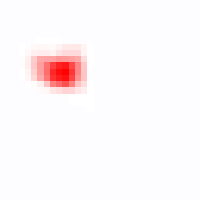

In [171]:
conditions = [{'convolutional_layers.3': [5], 'y': [2]}]

heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, 1),resize=200)

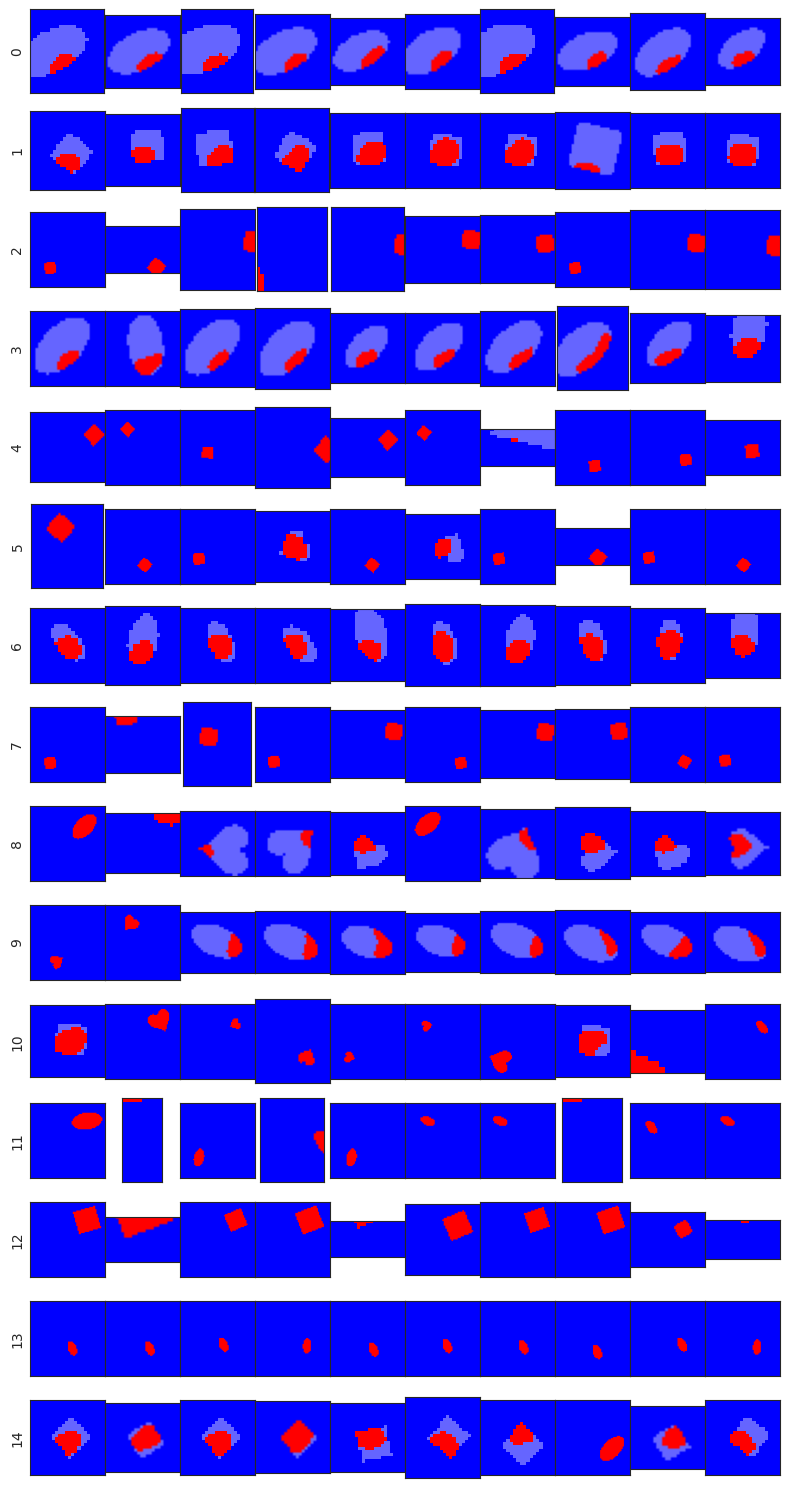

In [66]:
cond_layer = 'linear_layers.0'
#cond_layer = "convolutional_layers.3"
vis_layers = range(15)


def vis_block(data_batch, heatmaps, rf=False, alpha=0.5, vis_th=0.2, crop_th=0.1, kernel_size=19):
    return vis_opaque_img(data_batch, heatmaps, rf=rf,alpha=0.2, vis_th=0.8, crop_th=0.1, kernel_size=19)

ref_c = fv.get_max_reference(vis_layers, cond_layer,"relevance", (0, 10), 
                             composite=composite, rf=True,plot_fn=vis_block)

plot_grid(ref_c, figsize=(8, len(vis_layers)), padding=False)

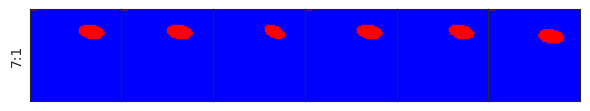

In [62]:
conc = 2

cond_layer = 'convolutional_layers.3'

targets, rel = fv.compute_stats(conc, cond_layer, "relevance", top_N=1, norm=True)

ref_t = fv.get_stats_reference(conc, cond_layer, targets, "relevance", (0, 6), composite=composite, plot_fn=vis_opaque_img)

plot_grid(ref_t, figsize=(6, 5), padding=False)


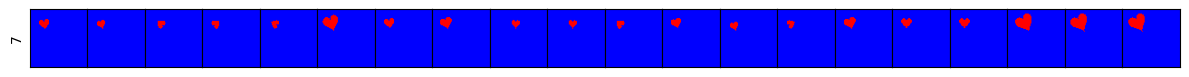

In [14]:
ref_c = fv.get_max_reference([7], "convolutional_layers.3", "relevance", (0, 20))

plot_grid(ref_c, figsize=(12, 40), padding=False)

In [37]:
# find most relevant neurons for a layer
cond_layer = 'linear_layers.2'
most_relevant = []
for blub in tqdm(range(100)):
    dataiter = iter(training_loader)
    images, labels = next(dataiter)
    images = images.view((BATCH_SIZE, 1,64,64))
    for i in range(len(labels)):
        index = i
        label = labels[index]
        img = images[index]
        sample = img.view(1,1,64,64)
        sample.requires_grad = True
        conditions = [{'y': [label]}]
        attr = attribution(sample, conditions, composite, record_layer=layer_names)

        rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)
        rel_values, concept_ids = torch.topk(rel_c[0], 2)
        most_relevant += [int(x) for x in concept_ids]
collections.Counter(most_relevant)

100%|█████████████████████████████████████████| 100/100 [00:36<00:00,  2.71it/s]


Counter({0: 12800, 1: 8483, 2: 4317})

In [40]:
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.causal_effects import CausalEffects
from tigramite.lpcmci import LPCMCI
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.regressionCI import RegressionCI

import statsmodels
# Seaborn for nice scatter plots
import seaborn as sns
import pandas as pd

In [41]:
with open('latents_values.pickle', 'rb') as f:
    latents_values = pickle.load(f)

In [46]:
def get_attribution_score(img, label, layer, neuron):
    conditions = [{layer: neuron, 'y': [label]}]
    a,b,c,d = attribution(img, conditions, composite, record_layer=layer_names)
    if layer.startswith("conv"):  
        return float(c[layer][0][neuron].sum())
    else:
        return float(c[layer][0][neuron])
    
def get_reference_scores(img, label, layer, neurons):
    conditions = [{ 'y': [label]}]
    attr = attribution(img, conditions, composite, record_layer=layer_names)
    rel_c = cc.attribute(attr.relevances[layer], abs_norm=True)
    return [rel_c[0][i] for i in neurons]
    
    
def get_relevant_scores(img, label, cond_layer, neurons):
    conditions = [{cond_layer: [x], 'y': [label]} for x in neurons]
    attr = attribution(img, conditions, composite, record_layer=layer_names)
    rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)
    return [rel_c[0][i] for i in neurons]

def get_most_relevant(img, label, cond_layer):
    conditions = [{'y': [label]}]
    attr = attribution(img, conditions, composite, record_layer=layer_names)
    rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)
    rel_values, concept_ids = torch.topk(rel_c[0], 5)
    return concept_ids

In [67]:
import math
most_rel = {
    27: 11909,
    28: 895,
    26: 891,
    37: 357,
    3: 350,
    12: 349,
    24: 342,
    9: 340,
    30: 338,
}
cond_layer = "convolutional_layers.3" # 'linear_layers.0'
neurons = [0,1,2,3,4,5,6,7]  #most_rel.keys() 

def draw_values(size):
    variables = []
    dataiter = iter(ci_loader)
    for blub in range(size):
        images, labels, indices = next(dataiter)
        images = images.view((BATCH_SIZE, 1,64,64))
        for i in range(len(labels)):
            index = i
            # only specific shape
            #if latents_values[indices[index]][1] != 3.0:
                #continue
            label = labels[index]
            img = images[index]
            sample = img.view(1,1,64,64)
            sample.requires_grad = True
            #in_variables = [latents_values[indices[index]][1]] #list(latents_values[indices[index]][1:])
            # add prediction as variable
            output = model(sample)
            pred = output.data
            in_variables = list(pred[:][0])
            # add relevance scores for neurons
            res = get_reference_scores(sample, label, cond_layer, neurons)
            in_variables += res
            if not np.all(np.isfinite(in_variables)):
                print(index)
            variables.append(in_variables)
    return np.array(variables, dtype=np.float64)


In [68]:
#classes_names = [i.decode() for i in metadata['latents_names']][1:]
classes_names = [ "rectangle", "heart", "ellipse"] #"label",
var_names = classes_names + [f'{cond_layer}_{k}' for k in neurons] 
data = draw_values(6) # n x SAMPLE_SIZE

data_type = np.zeros(data.shape, dtype='int')
data_type[:,0] = 0 #1
data_type[:,1:] = 0
print(var_names, len(data[0]), len(var_names), len(data), data[0])

dataframe = pp.DataFrame(data, var_names=var_names)#data_type=data_type)

['rectangle', 'heart', 'ellipse', 'convolutional_layers.3_0', 'convolutional_layers.3_1', 'convolutional_layers.3_2', 'convolutional_layers.3_3', 'convolutional_layers.3_4', 'convolutional_layers.3_5', 'convolutional_layers.3_6', 'convolutional_layers.3_7'] 11 11 768 [-2.59256721 -2.59235168  6.22511387  0.          0.          0.65065724
  0.10445285  0.1127805   0.         -0.06194592  0.07016344]


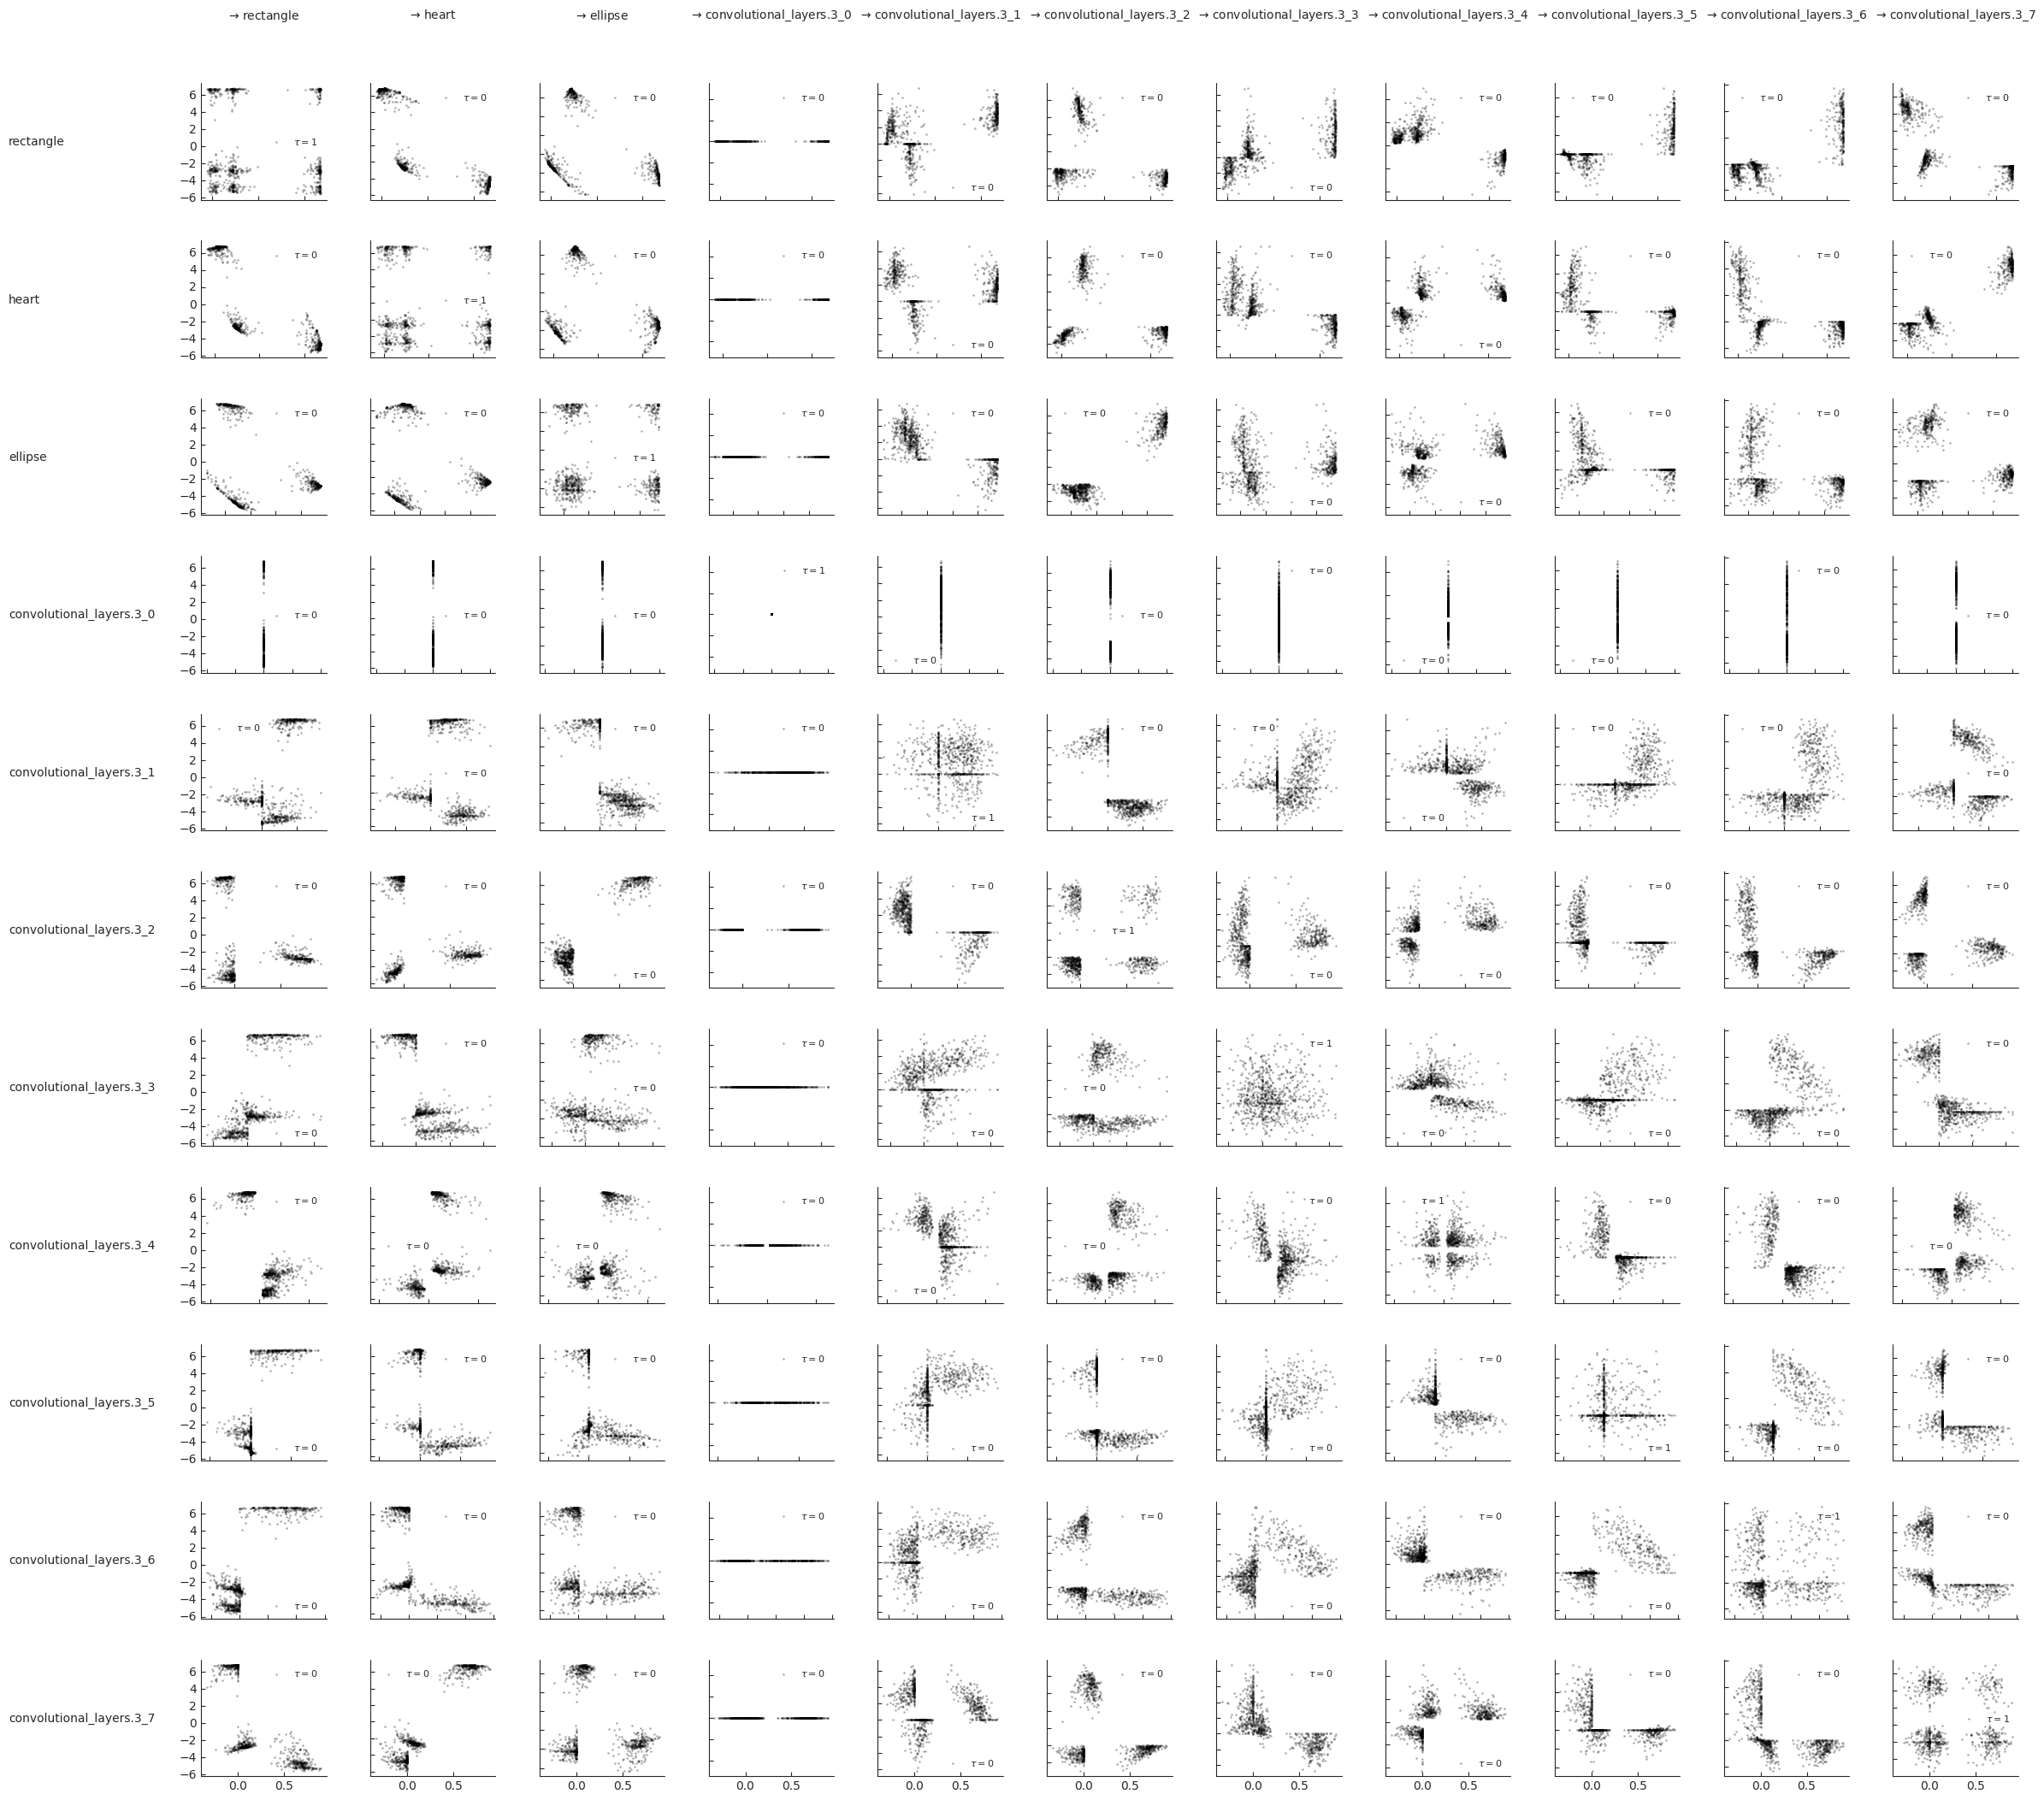

In [69]:
matrix_lags = None #np.argmax(np.abs(correlations), axis=2)
setup_args = {"figsize": (25,22),"label_space_left": 0.1,"label_space_top": 0.05}
tp.plot_scatterplots(dataframe=dataframe, add_scatterplot_args={'matrix_lags':matrix_lags}, 
                    setup_args=setup_args); plt.show()

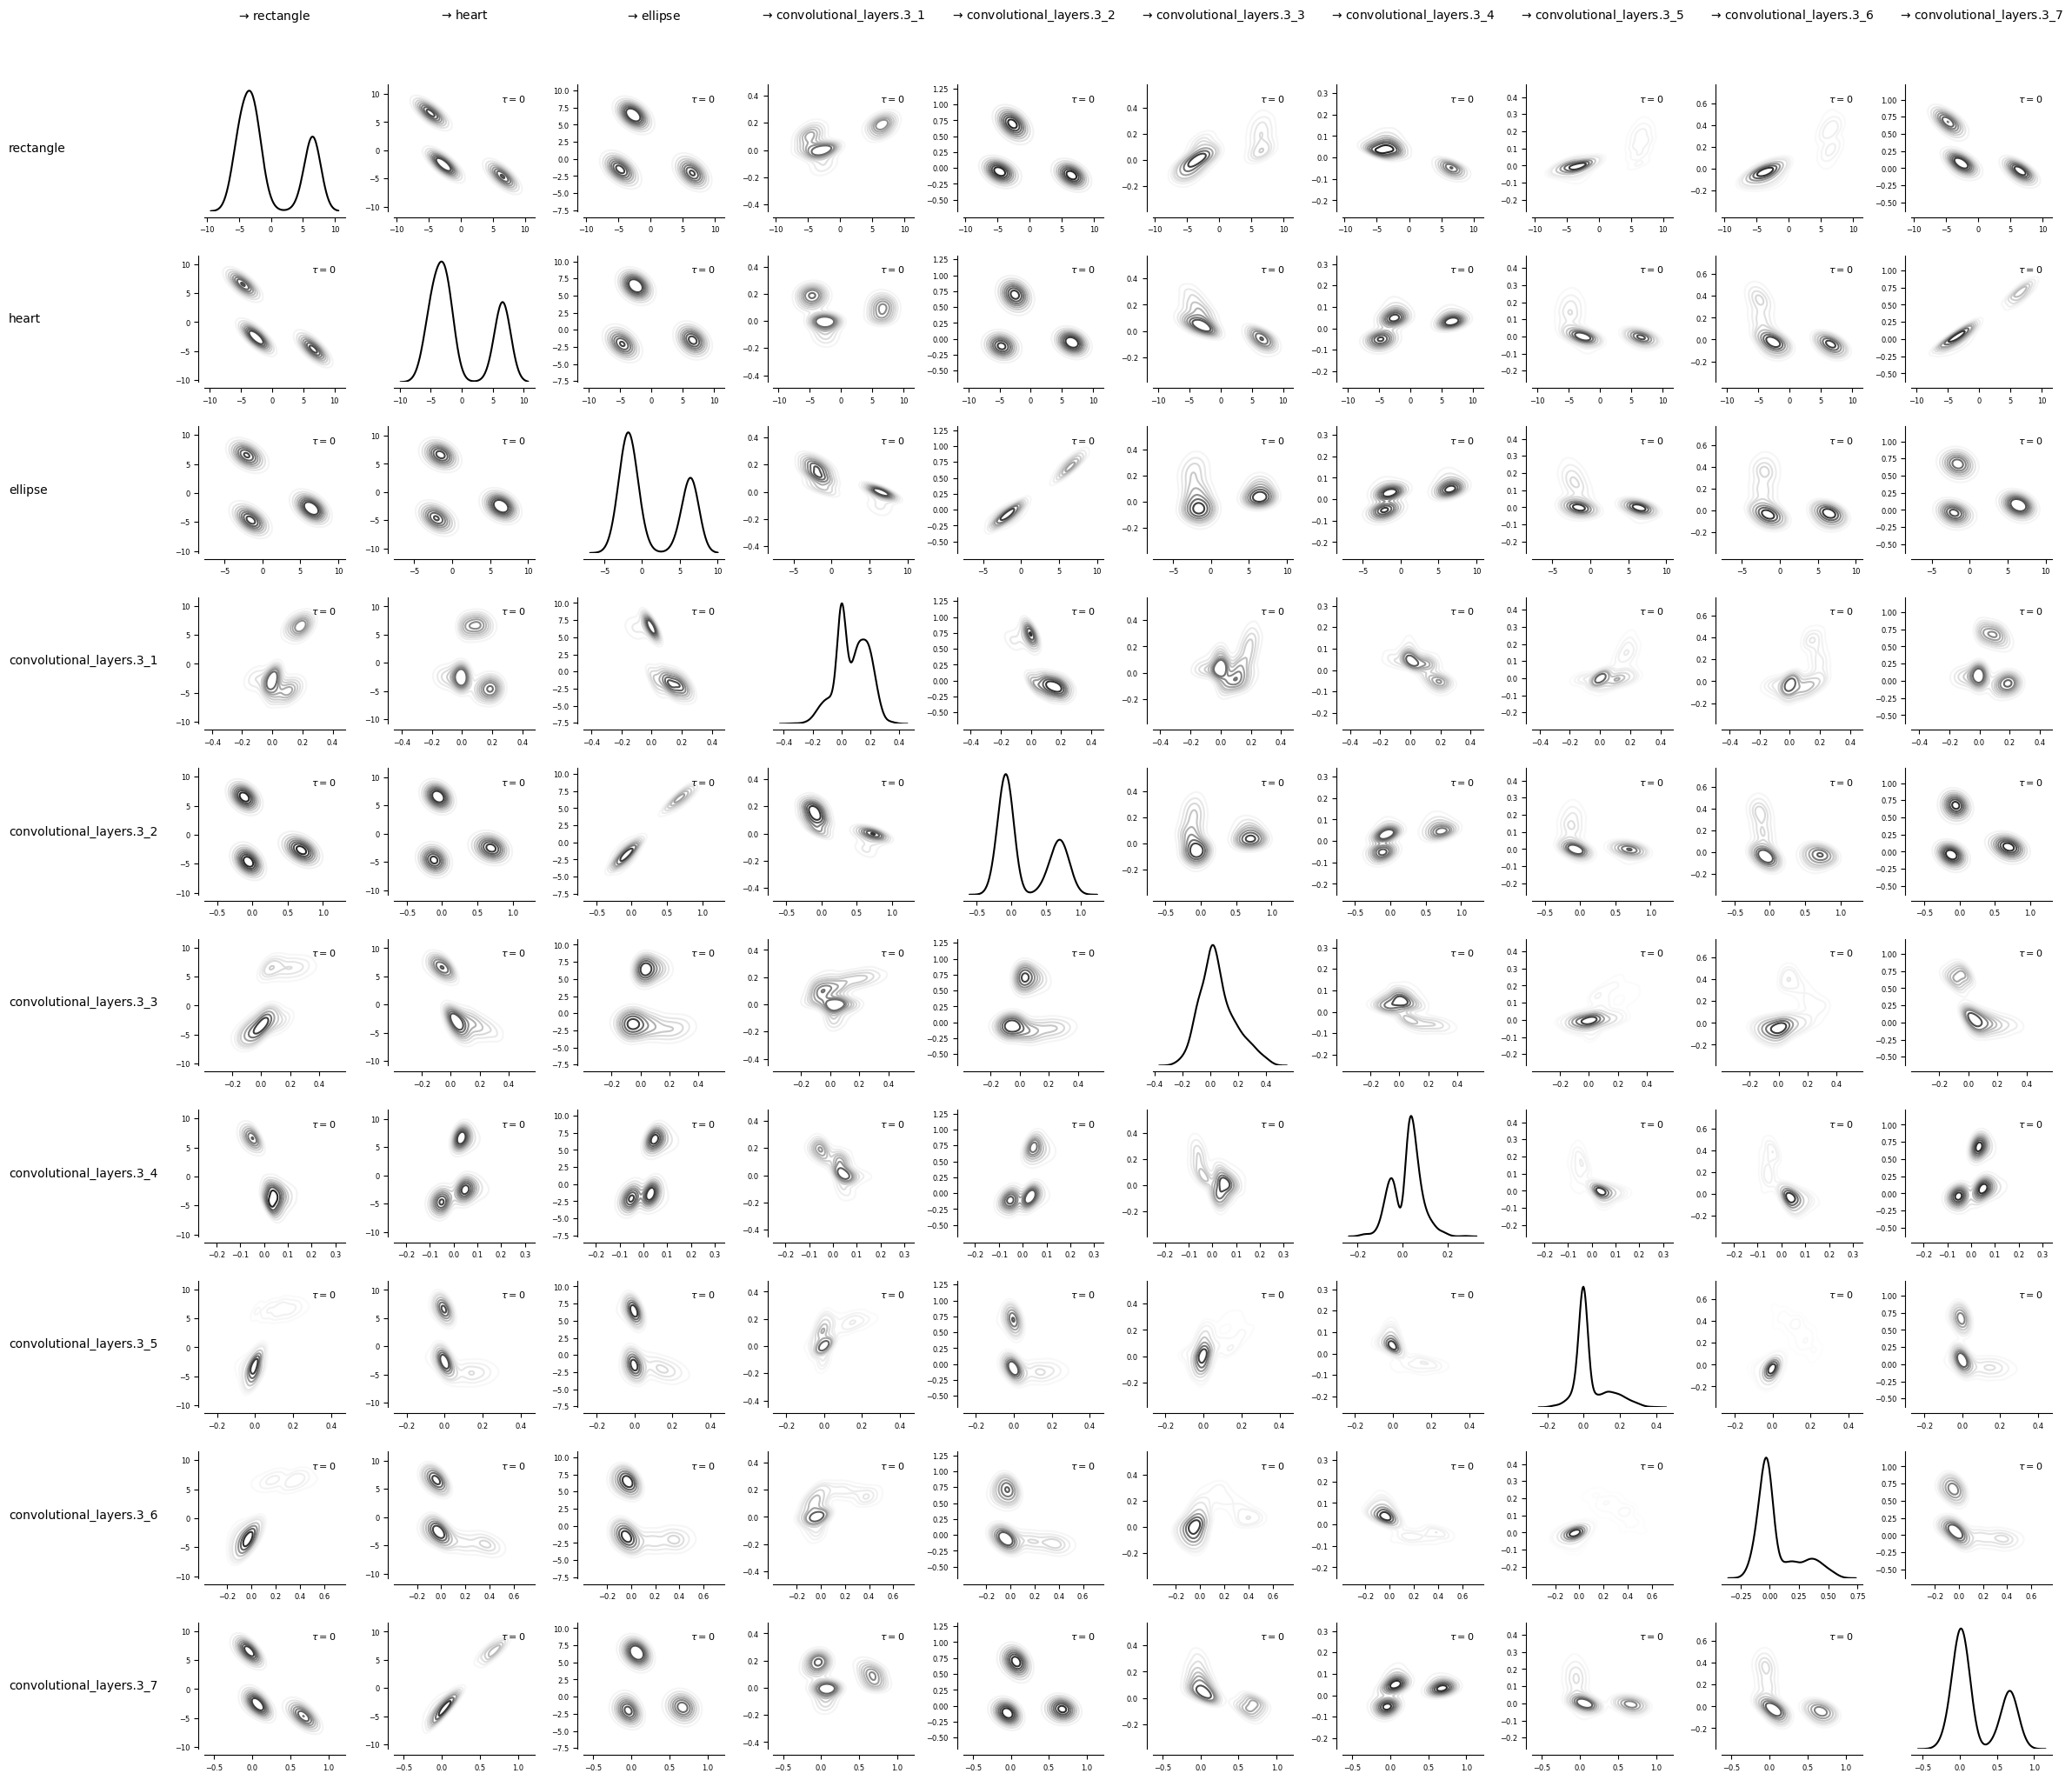

In [58]:
tp.plot_densityplots(dataframe=dataframe, add_densityplot_args={'matrix_lags':matrix_lags}, setup_args=setup_args)
plt.show()

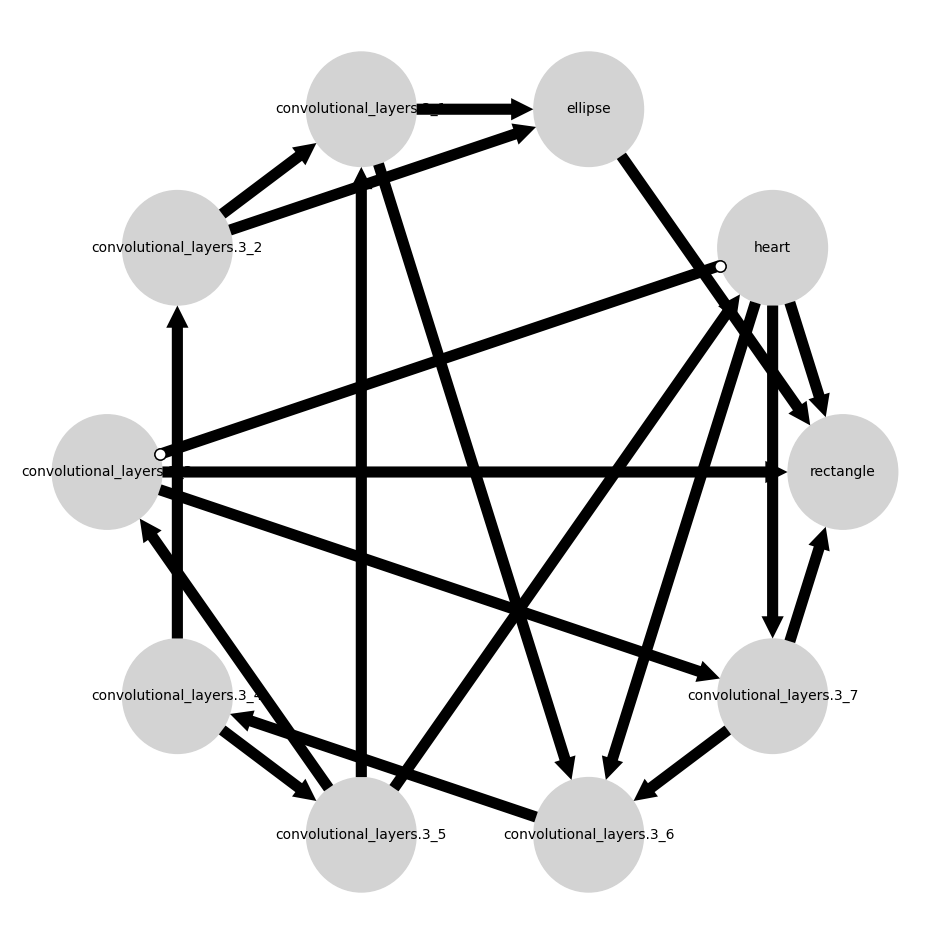

In [55]:
#ci_test = CMIknn()#(significance='analytic')
ci_test = RobustParCorr(significance='analytic')
#ci_test = GPDC() 
#ci_test = CMIsymb()
#ci_test = RegressionCI(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=ci_test,
    verbosity=1)


results = pcmci.run_pcalg_non_timeseries_data()

tp.plot_graph(graph=results['graph'], save_name=None, 
            var_names=var_names, 
                          figsize=(12, 12), 
                        ); plt.show()

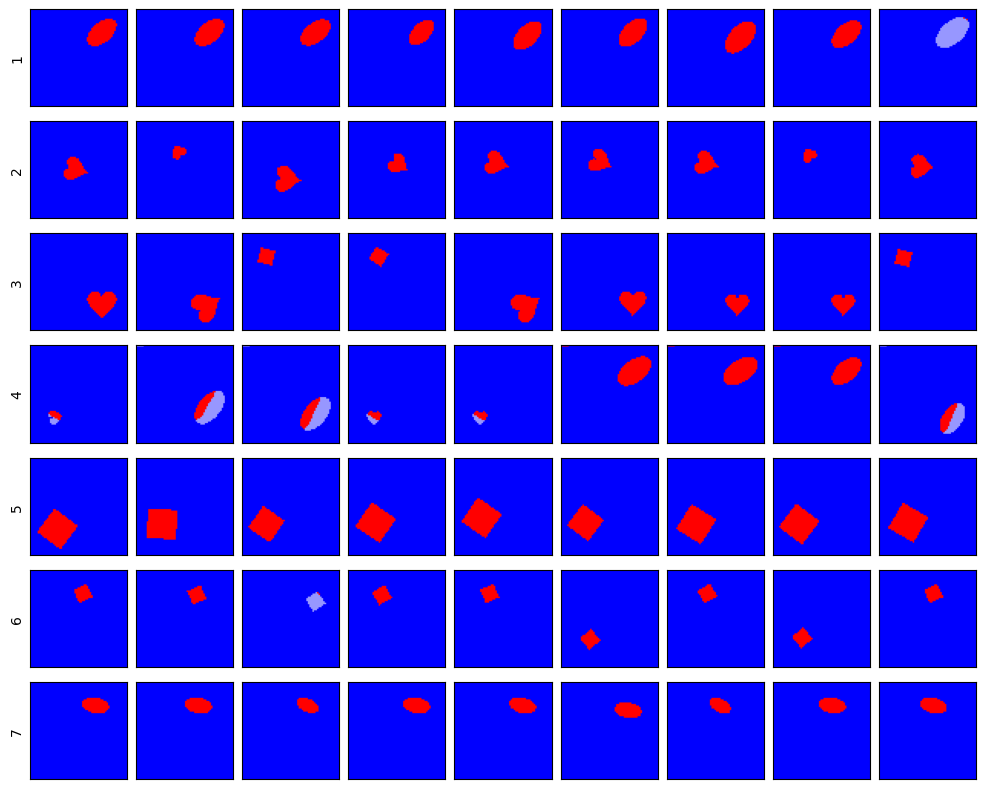

In [56]:
from crp.image import vis_opaque_img
#sel_neruons = range(8)

ref_c = fv.get_max_reference(neurons, cond_layer, "relevance", (0, 9), composite=composite, 
                             plot_fn=vis_opaque_img)

plot_grid(ref_c, figsize=(10, len(sel_neruons)))

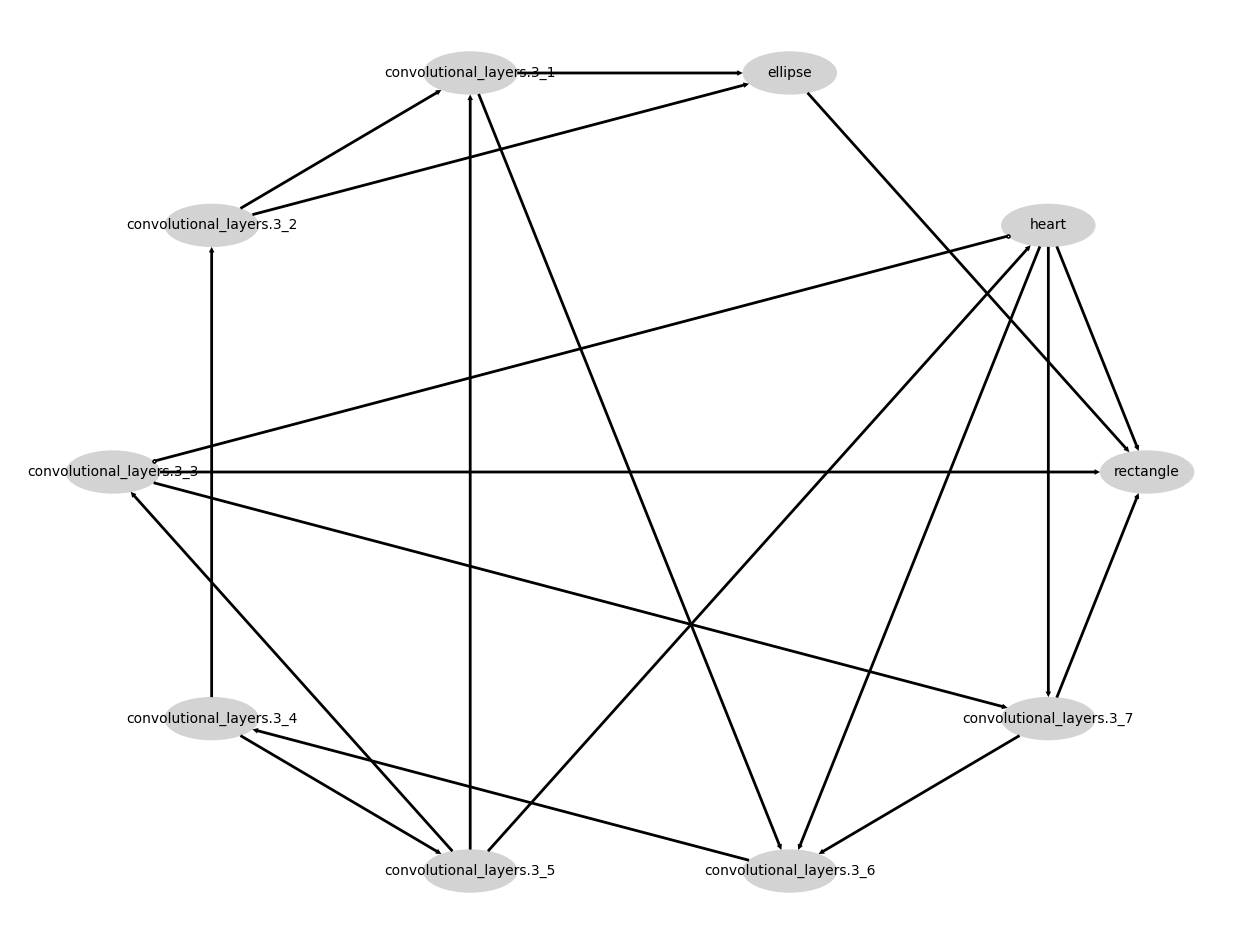

In [57]:
node_pos = {
    'x': [8,8,8,8,8,7,6,6,5,4,3,2,1,0,1,2,3,4,5,6,7], 
    'y': [1,3,5,7,9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
}

tp.plot_graph(graph=results['graph'], save_name=None, 
            var_names=var_names, 
                          figsize=(16, 12), arrow_linewidth=2,node_size=0.1,node_aspect=1.8, label_fontsize=16
                        ); plt.show()